In [1]:
#0.48500 <- elim std>3, 12-300-30-10-1
#0.52512 <- Epoch 11/200  16s - loss: 0.4993 - val_loss: 0.3509
#0.38798 <- 12-300-30-5-1
#0.41785<- 9col grp1 loss: 0.3123 - acc: 0.0000e+00 - val_loss: 0.2602
#0.43247 <-3col 
#0.53085 <- adadelta
#0.50647 <-decay
#0.48978 <-rmsle

#task
# feature extraction
# feature selection
# optimizaer selection , lr , decay

In [1]:
### importing libraries
%matplotlib inline
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Convolution1D
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop
from keras.datasets import mnist
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import matplotlib as mpl

#mpl.use('Agg')
import matplotlib.pyplot as plt
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

Using TensorFlow backend.


20170502-021629


In [64]:
df_train = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'])

df_train.head()

id  timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1 2011-08-20       43     27.0    4.0        NaN       NaN         NaN   
1   2 2011-08-23       34     19.0    3.0        NaN       NaN         NaN   
2   3 2011-08-27       43     29.0    2.0        NaN       NaN         NaN   
3   4 2011-09-01       89     50.0    9.0        NaN       NaN         NaN   
4   5 2011-09-05       77     77.0    4.0        NaN       NaN         NaN   

   num_room  kitch_sq    ...      cafe_count_5000_price_2500  \
0       NaN       NaN    ...                               9   
1       NaN       NaN    ...                              15   
2       NaN       NaN    ...                              10   
3       NaN       NaN    ...                              11   
4       NaN       NaN    ...                             319   

  cafe_count_5000_price_4000 cafe_count_5000_price_high  \
0                          4                          0   
1                          3                          0   
2                          3                          0   
3                          2                          1   
4                        108                         17   

   big_church_count_5000  church_count_5000  mosque_count_5000  \
0                     13                 22                  1   
1                     15                 29                  1   
2                     11                 27                  0   
3                      4                  4                  0   
4                    135                236                  2   

   leisure_count_5000  sport_count_5000  market_count_5000  price_doc  
0                   0                52                  4    5850000  
1                  10                66                 14    6000000  
2                   4                67                 10    5700000  
3                   0                26                  3   13100000  
4                  91               195                 14   16331452  

[5 rows x 292 columns]

In [65]:
print( df_train.shape)

(30471, 292)


In [66]:
# This section added:  drop crazy data point
print( df_train.life_sq.max() )

gr1=["full_sq", "life_sq", "floor", "max_floor", "material", "build_year", \
     "num_room", "kitch_sq","state", "material","radiation_km","green_zone_km"]

clist = gr1#['life_sq','floor']
for cname in clist:
 df_train.drop(df_train[np.abs((df_train[cname]-df_train[cname].mean())/df_train[cname].std())>3].index, inplace=True)

print( df_train.shape)

7478.0
(28544, 292)


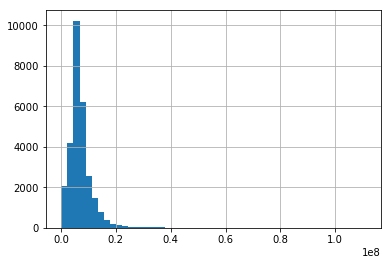

In [67]:
df_train['price_doc'].hist(bins=50)

In [68]:
y_train = df_train['price_doc'].values
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
print(df_all.shape)

# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
#df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
#df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

(36206, 390)


In [69]:
factorize = lambda t: pd.factorize(t[1])[0]

df_obj = df_all.select_dtypes(include=['object'])

X_all = np.c_[
    df_all.select_dtypes(exclude=['object']).values,
    np.array(list(map(factorize, df_obj.iteritems()))).T
]
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

(36206, 392)


In [70]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

df_values=df_values.fillna(df_values.mean())
df_values=df_values.dropna(axis="columns", how='all')

df_values.drop(['area_m','ID_metro'], axis=1, inplace=True)

#gr1=["full_sq", "life_sq", "floor", "max_floor", "material", "build_year", \
#     "num_room", "kitch_sq","state", "material","radiation_km","green_zone_km"]
df_values=df_values[gr1]
#df_values.mean()
df_values.shape

(36206, 12)

In [71]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

df_columns = df_values.columns.tolist
df_columns

(36206, 12)


<bound method Index.tolist of Index(['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year',
       'num_room', 'kitch_sq', 'state', 'material', 'radiation_km',
       'green_zone_km'],
      dtype='object')>

In [72]:
#X_all.tofile("x_all.csv",format="%s",sep=",")

In [73]:
#df_valuesclean=df_values.dropna(axis="columns", how='any')
#df_valuesclean.shape

In [74]:
#df_valuesclean.to_csv("x_allpd.csv")

In [75]:
# define base model
def baseline_model():
    model = Sequential()
    #model.add(Convolution1D(20, 5, border_mode='valid', input_shape=(244, 1)))
    
    model.add(Dense(300, input_dim=df_values.shape[1], activation='relu'))
    #model.add(Convolution1D(20, 5, strides=1, padding='valid', dilation_rate=1, activation='relu')) 
    #model.add(Flatten())
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(30,activation="relu"))
    model.add(Dropout(0.5))
    #model.add(Dense(30,activation="relu"))
    #model.add(Dropout(0.5))
    #model.add(BatchNormalization())
    model.add(Dense(10,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(1,activation="relu"))
    # Compile model
    #sgd=SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(loss='mean_squared_logarithmic_error', optimizer=RMSprop(decay=0.0001))
        #Adadelta
        #sgd
    return model

In [76]:
model=baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 300)               3900      
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 30)                9030      
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                310       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total para

In [77]:

#model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
print ("^^^INFO: Fit Model^^^")
#X_train = X_train.reshape(X_train.shape[0],244,1)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=2)
]

history = model.fit(X_train, y_train, epochs=200, batch_size=180, validation_split=0.3, verbose=2,callbacks=callbacks) #verbose=2 )#

^^^INFO: Fit Model^^^
Train on 19980 samples, validate on 8564 samples
Epoch 1/200
0s - loss: 132.3961 - val_loss: 73.8800
Epoch 2/200
0s - loss: 63.6261 - val_loss: 39.7203
Epoch 3/200
0s - loss: 32.3433 - val_loss: 19.9219
Epoch 4/200
0s - loss: 15.3707 - val_loss: 9.4168
Epoch 5/200
0s - loss: 7.4611 - val_loss: 4.3137
Epoch 6/200
0s - loss: 3.4295 - val_loss: 1.8711
Epoch 7/200
0s - loss: 1.8651 - val_loss: 0.8784
Epoch 8/200
0s - loss: 1.5252 - val_loss: 0.6904
Epoch 9/200
0s - loss: 1.1402 - val_loss: 0.6423
Epoch 10/200
0s - loss: 0.9828 - val_loss: 0.6056
Epoch 11/200
0s - loss: 0.9128 - val_loss: 0.5740
Epoch 12/200
0s - loss: 0.8288 - val_loss: 0.5438
Epoch 13/200
0s - loss: 0.8795 - val_loss: 0.5120
Epoch 14/200
0s - loss: 0.8662 - val_loss: 0.4880
Epoch 15/200
0s - loss: 0.7066 - val_loss: 0.4619
Epoch 16/200
0s - loss: 0.7373 - val_loss: 0.4361
Epoch 17/200
0s - loss: 0.6763 - val_loss: 0.4156
Epoch 18/200
0s - loss: 0.7037 - val_loss: 0.3973
Epoch 19/200
0s - loss: 0.7348

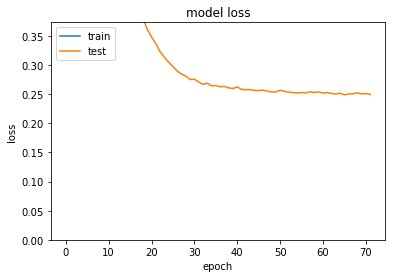

In [78]:
# list all data in history
'''
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([0,120])
# axes.set_ylim([90,100])
#plt.savefig('acc.png')  # save the figure to file
plt.show()
#plt.close()
'''


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('loss.png')
#plt.show()

plt.ylim([0, \
          min(history.history['val_loss'])+min(history.history['val_loss'])/2])
plt.show()
#plt.close()

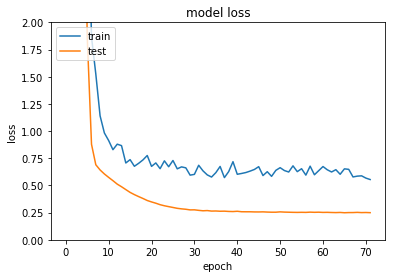

In [79]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.ylim([0, 2])
plt.show()

In [52]:
#X_test = X_test.reshape(X_test.shape[0],244,1)

In [80]:
y_test=model.predict(X_test)

In [81]:
y_test[:,0].shape

(7662,)

In [82]:
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_test[:,0]})

df_sub.to_csv('sub 2017-04-30_rmsle_12_elimOut.csv', index=False) 

# old LB score  0.47631

#Epoch 25/25
#8s - loss: 0.3268 - acc: 0.0000e+00 - val_loss: 0.3183 - val_acc: 0.0000e+00, now  0.48978


#0.50647 with decay

 #0.5308 ada delta 
    
    #Epoch 173/205
#0s - loss: 0.3716 - acc: 0.0000e+00 - val_loss: 0.3339 - val_acc: 0.0000e+00